In [29]:
import os
import tensorflow as tf
from tensorflow.core.util import event_pb2
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

figsize=(15, 10)
export_dir = './plots/'
data_dir = '/home/yuxin/ray_results/PPO/PPO_meltingpot_'
env_name = 'Pure Coordination'
env_list = ['Pure_Coordination_S_5M','Pure_Coordination_M_5M','Pure_Coordination_L_5M','Pure_Coordination_O_5M']
total_timestep = 6e6

sns.set()
sns.set_context("talk")
sns.set_style("darkgrid", {"axes.facecolor":".93"})

In [30]:
def get_section_results(file, env_name, *tags):
    data_dict = {'env_step': [], 'env_name': []}
    data_dict.update({tag: [] for tag in tags})
    max_step = -1
    for e in tf.compat.v1.train.summary_iterator(file):
        prev_step = -1
        for v in e.summary.value:
            if v.tag in data_dict:
                data_dict[v.tag].append(v.simple_value)
                if prev_step != e.step:
                    prev_step = e.step
                    if max_step < e.step:
                        max_step = e.step
                        data_dict['env_step'].append(e.step)
                        data_dict['env_name'].append(env_name)
    data_dict = {tag: np.array(data_dict[tag]) for tag in data_dict}
    return data_dict

In [31]:
def read_evaluation_data(env_list, size, smooth_alpha):
    full_data = pd.DataFrame()
    plot_data = pd.DataFrame()

    for env in env_list:
        logdir = os.path.join(data_dir+env, 'events*')
        print(logdir)
        eventfile = glob.glob(logdir)[0]
        data_dict = get_section_results(eventfile, env, 'ray/tune/policy_reward_min/agent_0',
                                        'ray/tune/policy_reward_mean/agent_0','ray/tune/policy_reward_max/agent_0')
        data = pd.DataFrame(data_dict)
        for (columnName, columnData) in data.items():
            if columnName != 'env_step' and columnName != 'env_name':
                data[f'{columnName}_smooth'] = data[columnName].ewm(alpha=smooth_alpha).mean()

        # reduce size for plotting
        count_row = data.shape[0]
        reduced_row = np.linspace(0, count_row-1, size, dtype=int, endpoint=True)
        data_p = data.iloc[reduced_row]

        full_data = pd.concat([full_data, data], axis=0)
        plot_data = pd.concat([plot_data, data_p], axis=0)
    return full_data, plot_data

In [32]:
data, data_plot = read_evaluation_data(env_list, 500, 0.2)

/home/yuxin/ray_results/PPO/PPO_meltingpot_Pure_Coordination_S_5M/events*


IndexError: list index out of range

In [ ]:
data_plot

,env_step,env_name,ray/tune/policy_reward_min/agent_0,ray/tune/policy_reward_mean/agent_0,ray/tune/policy_reward_max/agent_0,ray/tune/policy_reward_min/agent_0_smooth,ray/tune/policy_reward_mean/agent_0_smooth,ray/tune/policy_reward_max/agent_0_smooth
0,3200,Stag_Hunt_S_5M,22.034920,24.861904,27.688889,22.034920,24.861904,27.688889
6,12800,Stag_Hunt_S_5M,22.034920,38.700714,54.788887,22.034920,33.583533,45.173206
12,22400,Stag_Hunt_S_5M,22.034920,35.524681,54.788887,22.034920,36.223017,52.680936
18,32000,Stag_Hunt_S_5M,22.034920,39.062099,57.708202,22.034920,37.998032,55.704500
25,43200,Stag_Hunt_S_5M,22.034920,40.619720,57.708202,22.034920,39.997632,57.292796
...,...,...,...,...,...,...,...,...
3096,4958400,Stag_Hunt_O_5M,11.588477,25.524015,51.518421,11.582975,25.625610,51.174211
3103,4969600,Stag_Hunt_O_5M,11.588477,25.732725,51.518421,11.587323,25.537271,51.446235
3109,4979200,Stag_Hunt_O_5M,11.588477,26.052105,51.518421,11.588175,25.795467,51.499498
3115,4988800,Stag_Hunt_O_5M,11.588477,25.842077,51.518421,11.588398,25.899452,51.513461


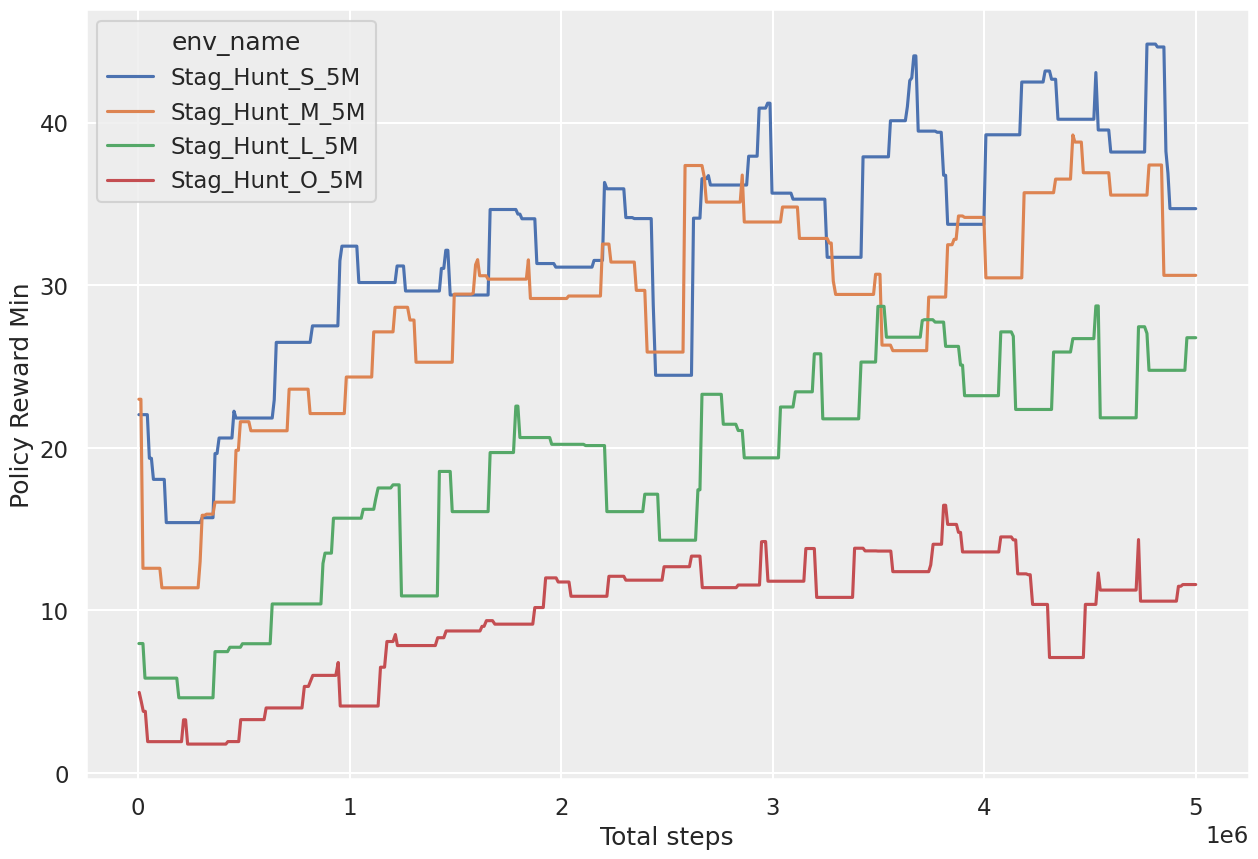

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=data_plot, x='env_step', y='ray/tune/policy_reward_min/agent_0', hue='env_name')
ax.set(xlabel='Total steps', ylabel='Policy Reward Min')
# plt.xticks(np.arange(0, total_timestep, 5e5))
# xlabels = ['{:.1f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
# g.set_xticklabels(xlabels)
plt.savefig(os.path.join(export_dir, env_name+' reward min.pdf'), bbox_inches='tight')

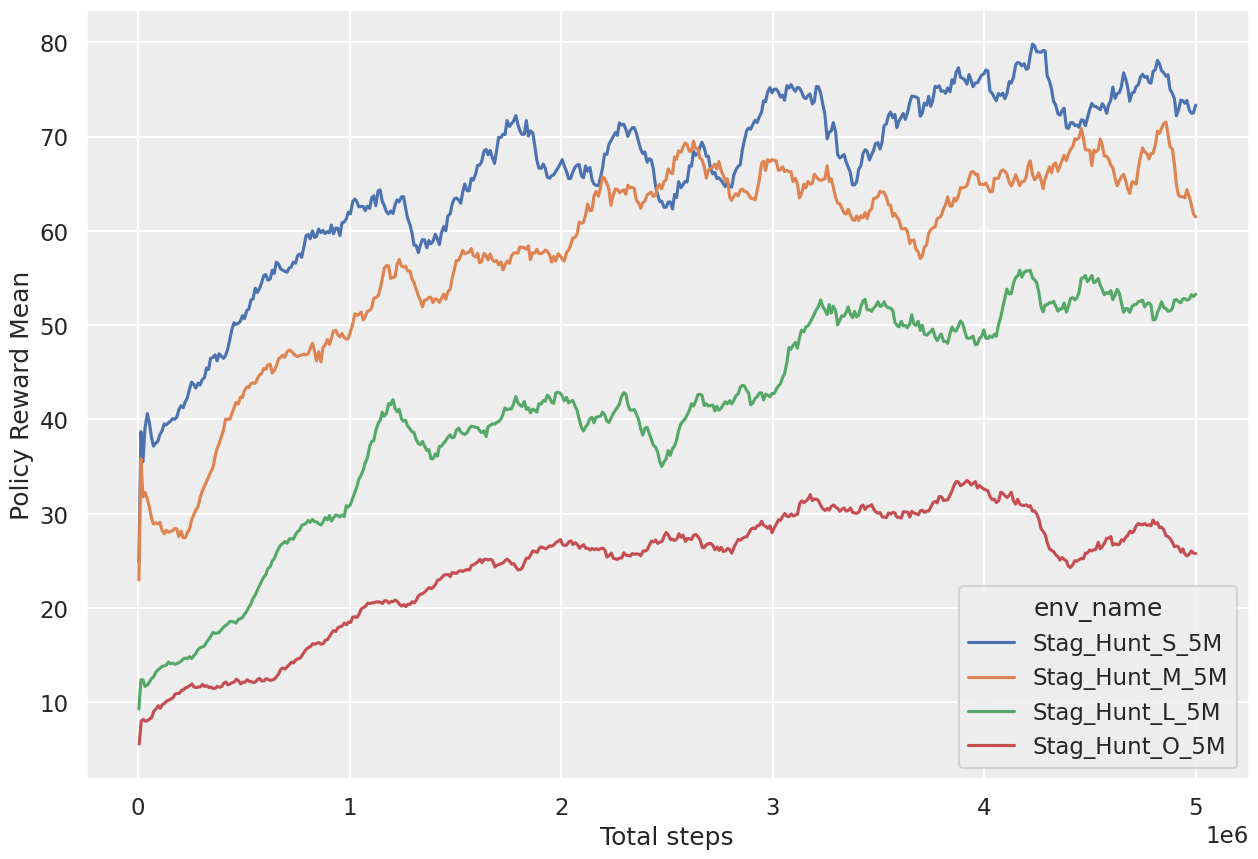

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=data_plot, x='env_step', y='ray/tune/policy_reward_mean/agent_0', hue='env_name')
ax.set(xlabel='Total steps', ylabel='Policy Reward Mean')
# plt.xticks(np.arange(0, total_timestep, 5e5))
# xlabels = ['{:.1f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
# g.set_xticklabels(xlabels)
plt.savefig(os.path.join(export_dir, env_name+' reward mean.pdf'), bbox_inches='tight')

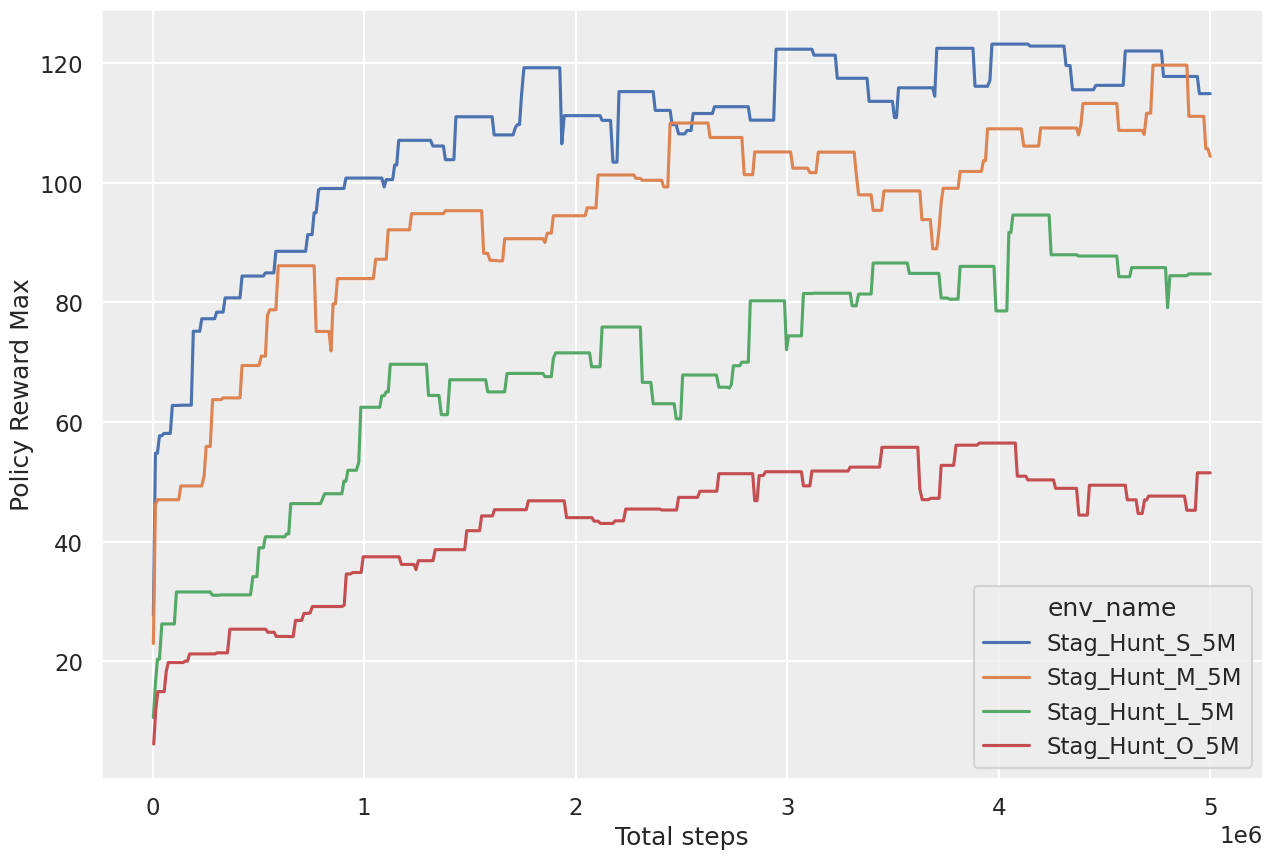

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=data_plot, x='env_step', y='ray/tune/policy_reward_max/agent_0', hue='env_name')
ax.set(xlabel='Total steps', ylabel='Policy Reward Max')
# plt.xticks(np.arange(0, total_timestep, 5e5))
# xlabels = ['{:.1f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
# g.set_xticklabels(xlabels)
plt.savefig(os.path.join(export_dir, env_name+' reward max.pdf'), bbox_inches='tight')